<a href="https://colab.research.google.com/github/rizaldns/Dashboard/blob/main/Project_DS_Predictive_Bank_Telemarketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BANK TELEMARKETING CAMPAIGN ANALYSIS & PREDICTION**

**Marketing campaigns** are characterized by focusing on the customer needs and their overall satisfaction. Nevertheless, there are different variables that determine whether a marketing campaign will be successful or not. There are certain variables that we need to take into consideration when making a marketing campaign.

**A Term deposit** is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time. For more information with regards to Term Deposits please click on this link from Investopedia: https://www.investopedia.com/terms/t/termdeposit.asp

# Main Objective
---
**Main Objective**: increase the effectiveness of the bank's telemarketing campaign
This project will enable the bank to develop a more granular understanding of its customer base, predict customers' response to its telemarketing campaign and establish a target customer profile for future marketing plans.




# Main Goals
---
**Main Goal**: By analyzing customer features, such as demographics and transaction history, the bank will be able to predict customer saving behaviours and identify which type of customers is more likely to make term deposits. The bank can then focus its marketing efforts on those customers. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain customers.

#Import Library
---




In [8]:
import os
import zipfile
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px 
from matplotlib import pyplot
import xgboost
from google.colab import drive
from google.colab import data_table
from sklearn.svm import SVC
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC  
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

#Data Gathering
---




In [9]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv('drive/My Drive/bank-full.csv', delimiter=";")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dataset Info
---





The data relates to a direct marketing campaign from a banking institution. The marketing campaign is based on telephone calls. Often, more than one contact to the same client is required, to access whether the product (bank term deposit) will be ('yes') or not ( 'not') subscribed by customer.

     
Header | Definition
---|---------
`Age`| Age of customer
`Job` | Job of customer
`Martial` | Martial status of customer  
`Education` |Customer education level
`Default` |  Has credit in default?
`Housing` | If costumer has housing loan
`Loan` | Has Personal Loan
`Balance` |Customer's individual balance
`Contact` | Communication type
`Month` |  Last contact month of year 
`Day` | Last contact day of the week
`Duration` |Last contact duration, in seconds
`Campaign` | Number of contacts performed during this campaign and for this client
`Pdays` | Number of days that passed by after the client was last contacted from a previous campaign
`Previous` | Number of contacts performed before this campaign and for this client
`Poutcome` |outcome of the previous marketing campaign 
`Deposit` | has the client subscribed a term deposit

In [10]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [11]:
df_train.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [12]:
df_train.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [13]:
df_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Note: There are not that much insights we can gain from the descriptive dataset since most of our descriptive data is located not in the "numeric" columns but in the "categorical columns".

# Data Preprocessing
---




In [14]:
#Function for Check Data Quality 
def check_data_quality(input_data):
  """
  Data quality is on the most importent before applying any missing learning model
  Some of ML models are very sensitive towards the missing value, duplicated data and others
  input_data: variable that you save to read the data
  """
  #Shows the result in the percentage of data duplication
  duplication = input_data.duplicated().sum()/input_data.shape[0]*100
  print("There are around {:.2f}% of data duplication \n".format(duplication))

  #Shows the result in the percentage of null value
  type_null = pd.DataFrame(input_data.dtypes).T.rename(index = {0: 'Columns Type'})
  type_null = type_null.append(pd.DataFrame(input_data.isnull().sum()).T.rename(index = {0: 'Amount of Null Values'}))
  type_null = type_null.append(pd.DataFrame(input_data.isnull().sum()/input_data.shape[0]*100).T.rename(index = {0: 'Percentage of Null Values'}))
  
  return(type_null.T)

In [15]:
check_data_quality(df_train)

There are around 0.00% of data duplication 



,Columns Type,Amount of Null Values,Percentage of Null Values
age,int64,0,0.0
job,object,0,0.0
marital,object,0,0.0
education,object,0,0.0
default,object,0,0.0
balance,int64,0,0.0
housing,object,0,0.0
loan,object,0,0.0
contact,object,0,0.0
day,int64,0,0.0


There is no missing value in this dataset. Nevertheless, there are values like “unknown”, “others”, which are helpless just like missing values. Thus, these ambiguous values are removed from the dataset.



In [16]:
df_clean = df_train.copy()
df_clean

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Feature Enginering

In [17]:
#Change column name: 'y' to 'response'
df_clean.rename(index=str, columns={'y': 'deposit'}, inplace = True)

**Change Unknown data**

In [18]:
#Change 'unknown' data in feature
for i in range(len(df_clean['poutcome'])):
  if df_clean['deposit'][i] == 'yes':
     df_clean[['poutcome']] = df_clean[['poutcome']].replace(['unknown'],'success')
  elif df_clean['deposit'][i] == 'no':
    df_clean[['poutcome']] = df_clean[['poutcome']].replace(['unknown'],'failure')

df_clean[['job','education','contact']] = df_clean[['job','education','contact']].replace(['unknown'],'other')
df_clean[['job']] = df_clean[['job']].replace(['admin.'],'admin')
df_clean['day'] = df_clean['day'].astype(object)


**Drop Outlier**

In [19]:
condition = df_clean.poutcome == 'other'
df_clean = df_clean.drop(df_clean[condition].index, axis = 0, inplace = False)

In [20]:
#Take out Outlier in 'balance'
from scipy.stats import zscore

df_clean[['balance']].mean()
df_clean[['balance']].mean()

df_clean['balance_outliers'] = df_clean['balance']
df_clean['balance_outliers']= zscore(df_clean['balance_outliers'])

condition1 = (df_clean['balance_outliers']>3) | (df_clean['balance_outliers']<-3 )
df_clean2 = df_clean.drop(df_clean[condition1].index, axis = 0, inplace = False)

In [21]:
df_clean3 = df_clean2.drop('balance_outliers', axis=1)

In [22]:
def convert(df_clean3, new_column, old_column):
    df_clean3[new_column] = df_clean3[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return df_clean3[new_column].value_counts()

convert(df_clean3, "deposit_binary", "deposit")

0    37785
1     4870
Name: deposit_binary, dtype: int64

In [23]:
#change duration from seconds to minutes
df_clean3['duration'] = df_clean3['duration'].apply(lambda n:n/60).round(2)

In [24]:
#Drop rows that 'duration' < 5s
condition2 = (df_clean3['duration']<5/60)
df_clean4 = df_clean3.drop(df_clean3[condition2].index, axis = 0, inplace = False)

In [25]:
#Drop customer values with 'other' education
condition3 = (df_clean4['education'] == 'other')
df_clean5 = df_clean4.drop(df_clean4[condition3].index, axis = 0, inplace = False)

In [26]:
#Change 'month' from words to numbers for easier analysis
lst = [df_clean5]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

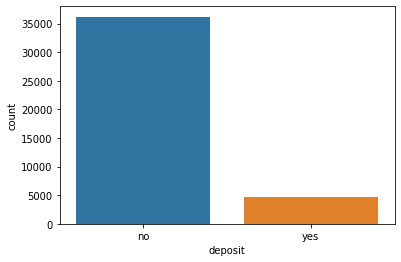

In [27]:
sns.countplot(data=df_clean5,x='deposit')

In [28]:
df_clean5['deposit'].value_counts()

no     36202
yes     4639
Name: deposit, dtype: int64

In [29]:
df_clean5 = df_clean5.query('balance >= 0')

In [30]:
df_clean5.describe()

,age,balance,duration,campaign,pdays,previous,deposit_binary,month_int
count,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000
mean,40.912955,1204.595442,4.315171,2.760506,32.750542,0.450759,0.118917,6.194284
std,10.591927,1731.377198,4.314751,3.066798,90.909747,1.596796,0.323695,2.405269
min,18.000000,0.000000,0.100000,1.000000,-1.000000,0.000000,0.000000,1.000000
25%,33.000000,137.000000,1.720000,1.000000,-1.000000,0.000000,0.000000,5.000000
50%,39.000000,514.000000,3.000000,2.000000,-1.000000,0.000000,0.000000,6.000000
75%,48.000000,1480.000000,5.320000,3.000000,-1.000000,0.000000,0.000000,8.000000
max,95.000000,10443.000000,81.970000,58.000000,871.000000,55.000000,1.000000,12.000000


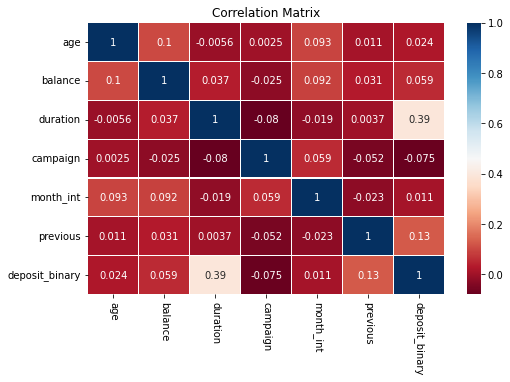

In [31]:
corr_data = df_clean5[['age','balance','duration','campaign','month_int','previous','deposit_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdBu',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.xticks(fontsize=10,rotation=-90)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

The scatter matrix does not reveal any clear relationship among age, balance, duration and campaign.

To investigate more about correlation, a correlation matrix was plotted with all qualitative variables. Clearly, “campaign outcome” has a strong correlation with “duration”, a moderate correlation with “previous contacts”, and mild correlations between “balance”, “month of contact” and “number of campaign”. Their influences on campaign outcome will be investigated further in the machine learning part.

#Exploration Data Analysis

---



## Univariate Analysis

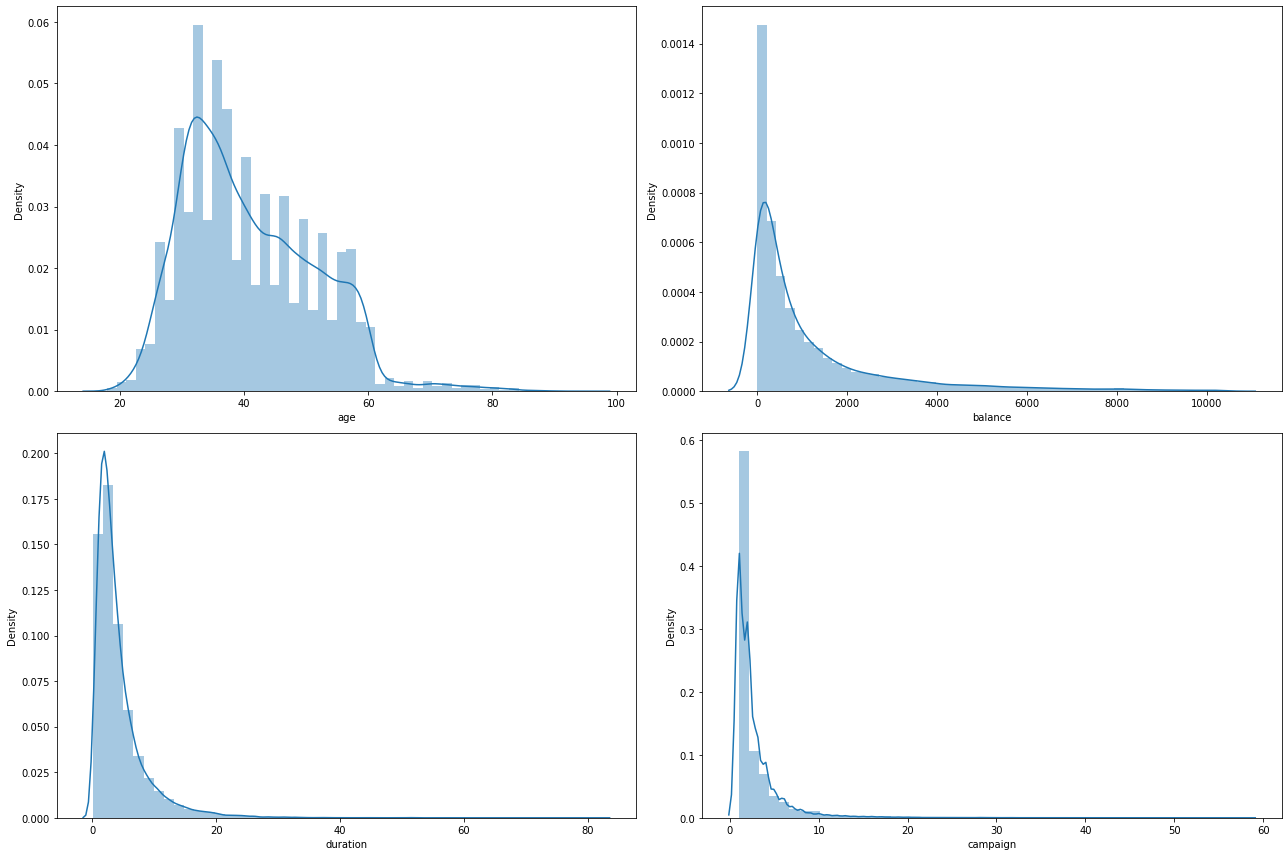

In [32]:
columns = ['age','balance','duration','campaign']

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(columns):
  plot = sns.distplot(df_clean5[col], ax=axes[i])

plt.tight_layout()

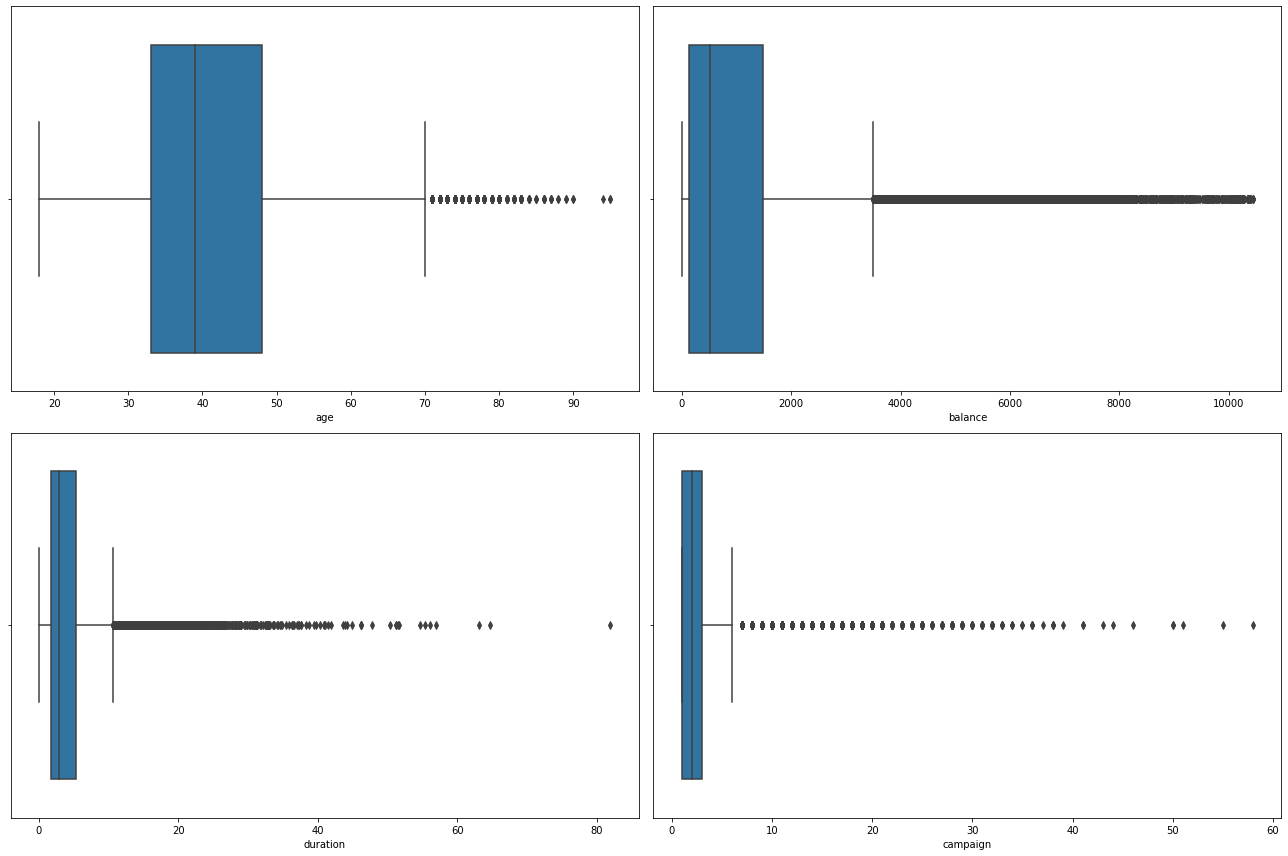

In [33]:
columns = ['age','balance','duration','campaign']

fig, axes = plt.subplots(2,2, figsize=(18,12))
axes = [ax for axes_row in axes for ax in axes_row]

for i, col in enumerate(columns):
  plot = sns.boxplot(df_clean5[col], ax=axes[i])

plt.tight_layout()

Insight Univariate analysis:

1. The distribution of 'Age' is right skewed, In this campaigns, clients called by the bank have an extensive age range, from 18 to 95 years old. However, from box-plot shown that majority of customers called is in the age of 30s and 45s (33 to 48 years old fall within the 25th to 75th percentiles). The distribution of customer age is fairly normal with a small standard deviation.

2. The distribution of balance: After dropping outliers in balance, the range of balance is still massive, from a minimum of -6847 to a maximum of 10443 euros, giving a range of 17290 euros. The distribution of balance has a huge standard deviation relative to the mean, suggesting large variabilities in customers' balance levels.

3. The distribution of duration: As observed from the box plot, the duration of contact has a median of 3 minutes, with an interquartile range of 2,5 minutes to 8 minutes. The left-skewed boxplot indicates that most calls are relatively short. Also, there is a large number of outliers ranging from 10 minutes to 40 minutes, which are worth further study.

4. The distribution of campaign: About half of the clients have been contacted by the bank for the second time, while 25% was first introduced to the term deposit. Most clients have been reached by the bank for one to three times, which is reasonable. However, some clients have been contacted by as high as 58 times, which is not normal. These clients may have some special needs that require frequent contact.


## Bivariate Analysis

**Relationship between each Feature with Last Campaign Success**

In [34]:
class CountPlot:
    def __init__(self, data, x, hue, title, figsize=(20, 10)):
        self.data = data
        self.x = x
        self.hue = hue
        self.title = title
        self.figsize = figsize

    def plot(self):
        plt.figure(figsize=self.figsize)
        ax = sns.countplot(x=self.x, hue=self.hue, data=self.data)

        # Add labels to the bars
        for p in ax.patches:
            ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=11, color='black', xytext=(0, 15),
                        textcoords='offset points')
 
        

        # Add a title to the plot
        plt.title(self.title)

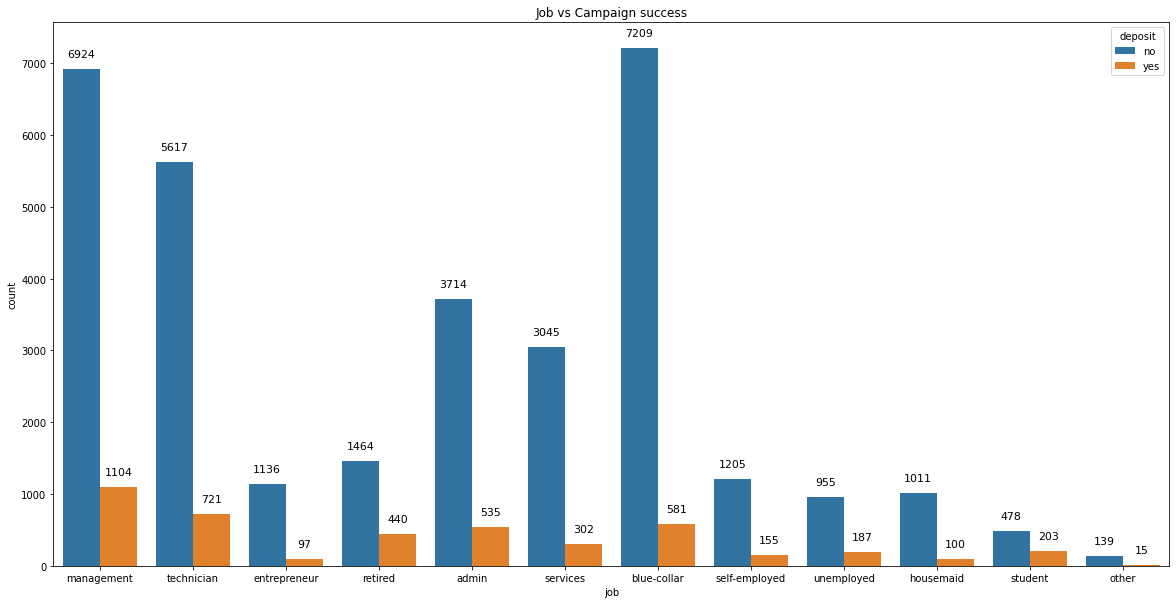

In [35]:
# Show 'Job vs campaign success'
plot = CountPlot(df_clean5, 'job', 'deposit','Job vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

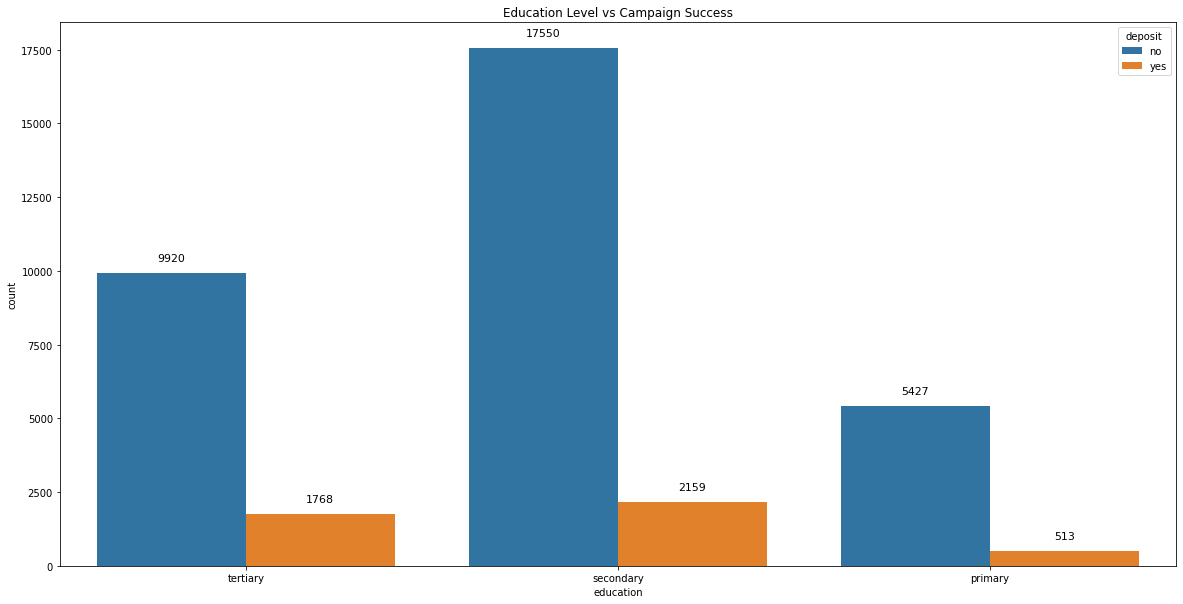

In [36]:
# Show 'Education vs campaign success'
plot = CountPlot(df_clean5, 'education', 'deposit','Education Level vs Campaign Success')
# Call the plot method to show the countplot
plot.plot()


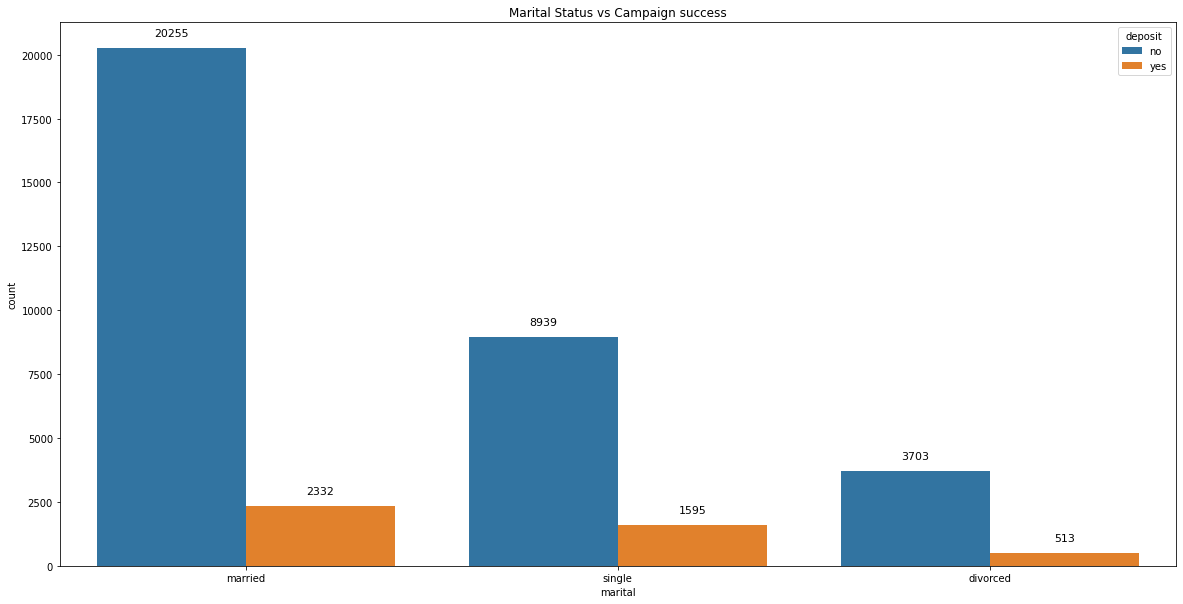

In [37]:
# Show 'Marital Status vs campaign success'
plot = CountPlot(df_clean5, 'marital', 'deposit','Marital Status vs Campaign success')
# Call the plot method to show the countplot
plot.plot()


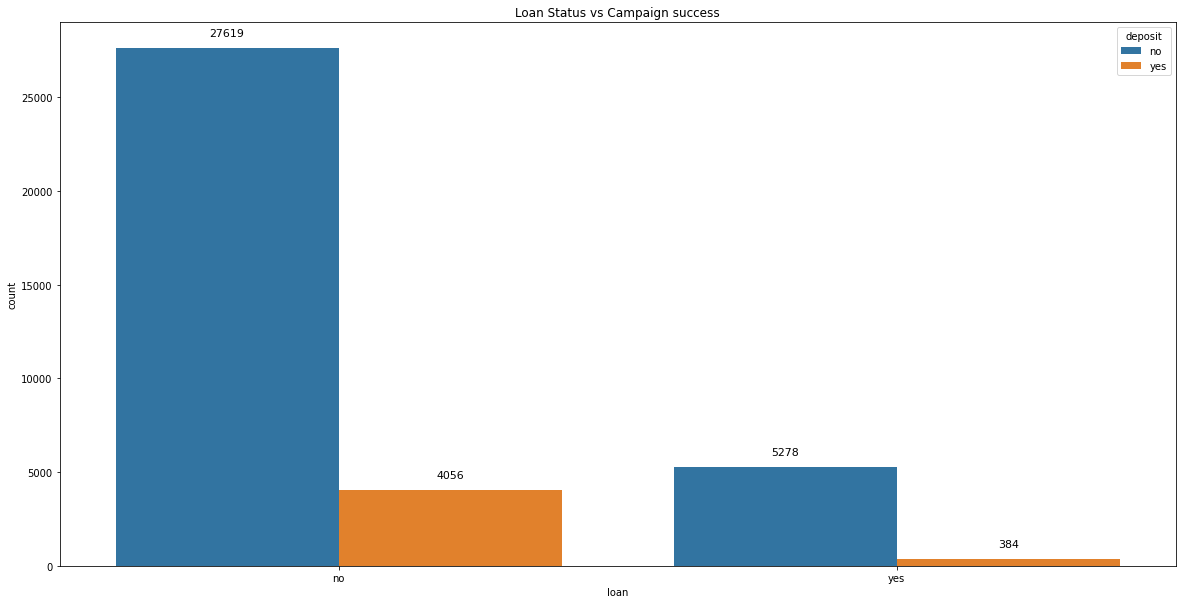

In [38]:
# Show 'Loan Status vs campaign success'
plot = CountPlot(df_clean5, 'loan', 'deposit','Loan Status vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

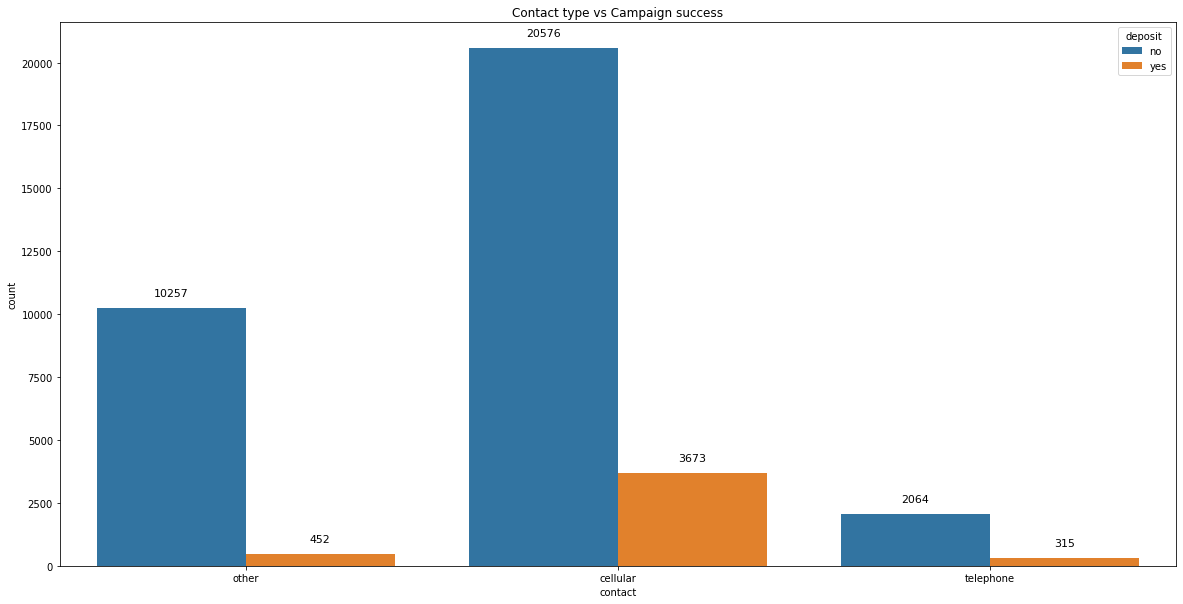

In [39]:
# Show 'Contact type vs campaign success'
plot = CountPlot(df_clean5, 'contact', 'deposit','Contact type vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

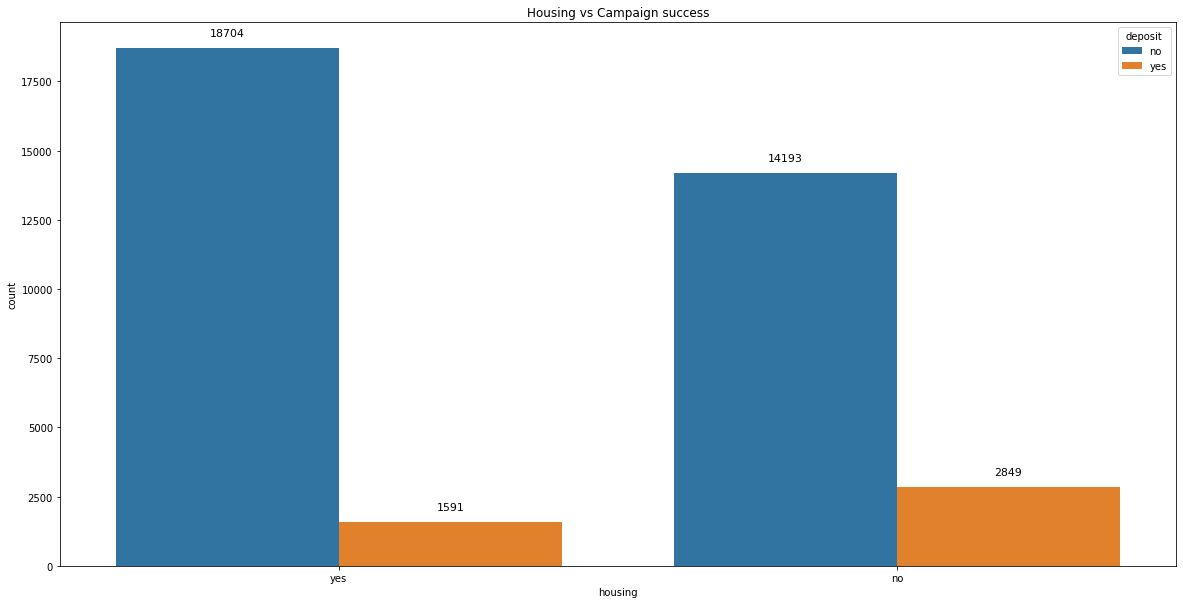

In [40]:
# Show 'Housing Status vs campaign success'
plot = CountPlot(df_clean5, 'housing', 'deposit','Housing vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

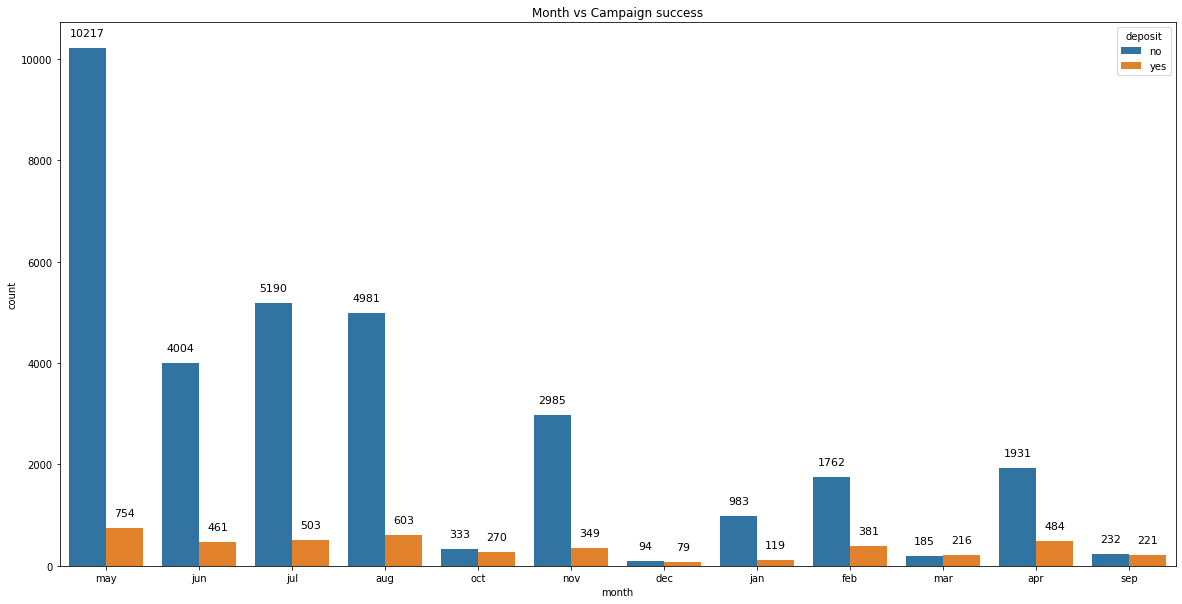

In [41]:
# Show 'Month vs campaign success'
plot = CountPlot(df_clean5, 'month', 'deposit','Month vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

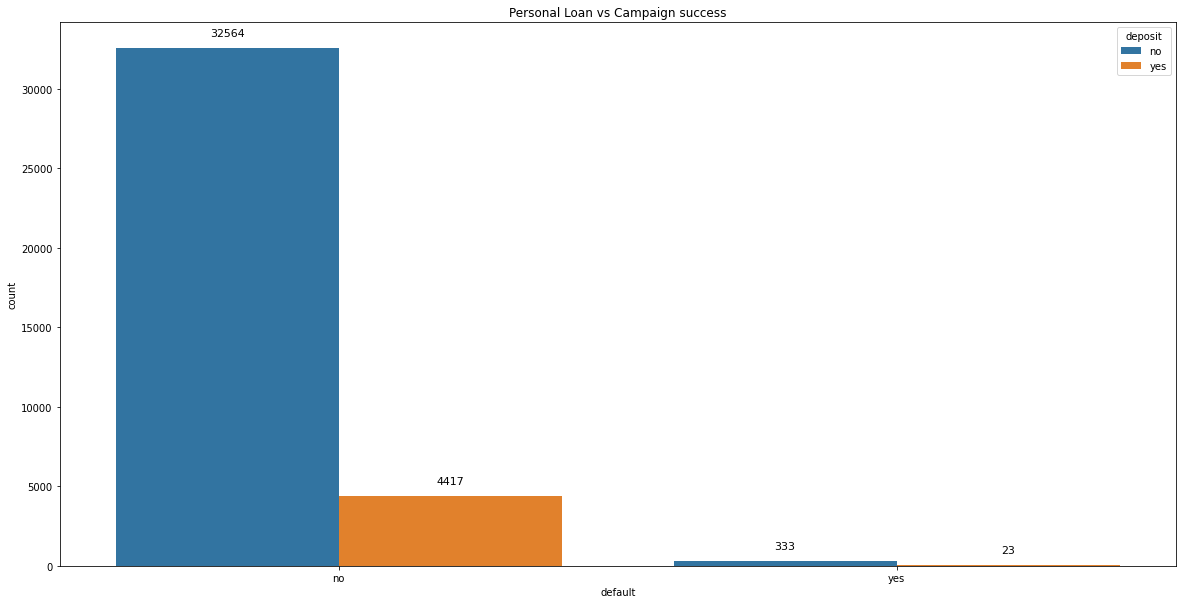

In [42]:
# Show 'Personal Loan vs campaign success'
plot = CountPlot(df_clean5, 'default', 'deposit','Personal Loan vs Campaign success')
# Call the plot method to show the countplot
plot.plot()

Insight:

1. Customers who previously accepted the deposit tends to accept the deposit.
2. Customers with job type as 'student' or 'retired' tends to accept the deposit, while blue collars tends to refuse the deposit.
3. Customer with married status tends to accept the deposit more than other
4. Customers without a personal loan tends to accept the deposit.
5. Customers without a Housing Loan tends to accept the deposit.
6. Customers tends to accept more the deposit on May and August
7. Customers tends to accept more when marketing contacted to their celular

This line chart displays the bank’s contact rate in each month as well as clients’ response rate in each month. One way to evaluate the effectiveness of the bank's marketing plan is to see whether these two lines have a similar trend over the same time horizon.

## **Multivariate Analysis**

relationship between 'duration' & 'campaign': with response result

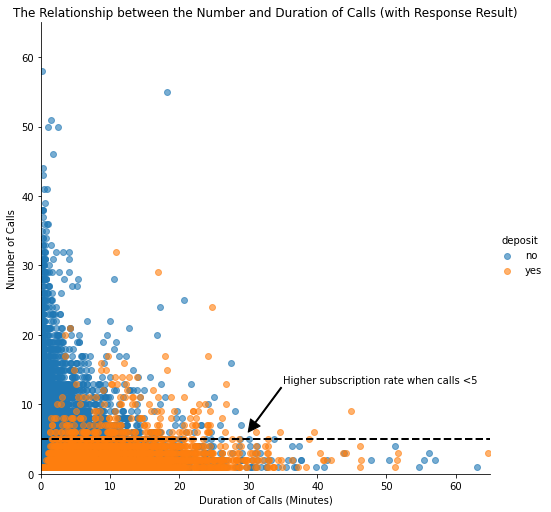

In [43]:
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = df_clean5,
                     hue = 'deposit',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

In this scatter plot, clients subscribed to term deposits are denoted as "yes" while those did not are denoted as "no".

As we can see from the plot, “yes” clients and “no” clients are forming two relatively separate clusters. Compared to “no” clients”, “yes” clients were contacted by fewer times and had longer call duration. More importantly, after five campaign calls, clients are more likely to reject the term deposit unless the duration is high. Most “yes” clients were approached by less than 10 times.

This suggests that the bank should resist calling a client for more than five times, which can be disturbing and increase dissatisfaction.

# **Data Visualization**



---



**Visualize the subscription and contact rate by age**

In [44]:
lst = [df_clean5]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

In [45]:
count_age_deposit_pct = pd.crosstab(df_clean5['deposit'],df_clean5['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_deposit_pct = count_age_deposit_pct.transpose() 

In [46]:
age = pd.DataFrame(df_clean5['age_group'].value_counts())
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_deposit_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

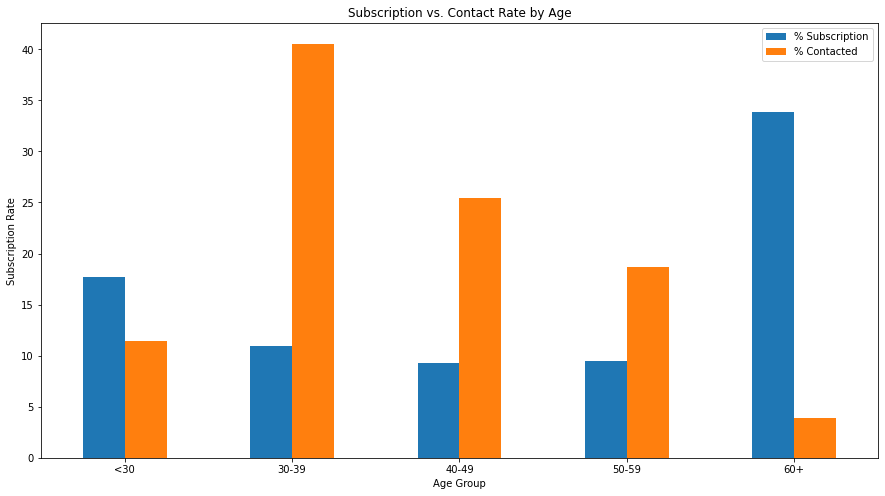

In [47]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(15,8),)
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

Insights: 

target the youngest and the oldest instead of the middle-aged

Blue bars indicate that clients with a age of 60+ have the highest subscription rate. About 17% of the subscriptions came from the clients aged between 18 to 29. More than 50% of the subscriptions are contributed by the youngest and the eldest clients.

It is not surprising to see such a pattern because the main investment objective of older people is saving for retirement while the middle-aged group tend to be more aggressive with a main objective of generating high investment income. Term deposits, as the least risky investment tool, are more preferable to the eldest.

The youngest may not have enough money or professional knowledge to engage in sophisticated investments, such as stocks and mutual funds. Term deposits provide liquidity and generate interest incomes that are higher than the regular saving account, so term deposits are ideal investments for students.



**Visualize the subscription rate by balance level**

In [48]:
lst = [df_clean5]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'

In [49]:
count_balance_deposit_pct = pd.crosstab(df_clean5['deposit'],df_clean5['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_deposit_pct = count_balance_deposit_pct.transpose()

In [50]:
bal = pd.DataFrame(df_clean5['balance_group'].value_counts())
bal['% Contacted'] = bal['balance_group']*100/bal['balance_group'].sum()
bal['% Subscription'] = count_balance_deposit_pct['yes']
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)

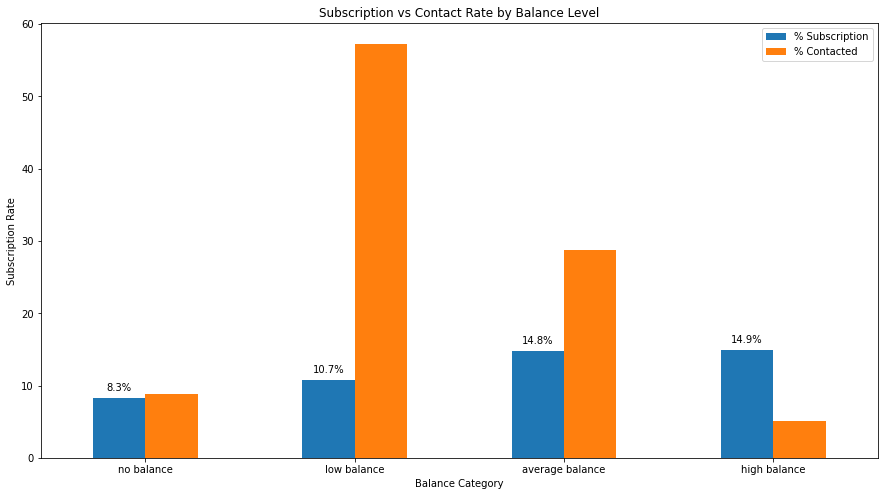

In [51]:
plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                                       figsize = (15,8))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2, 
                      rec.get_height() + 1, 
                      label+'%',  
                      ha = 'center', 
                      color = 'black')

Insights: 

To identify the trend more easily, clients are categorized into four groups based on their levels of balance:

No Balance: clients with a negative balance.
Low Balance: clients with a balance between 0 and 1000 euros
Average Balance: clients with a balance between 1000 and 5000 euros.
High Balance: clients with a balance greater than 5000 euros.
Unsurprisingly, this bar chart indicates a positive correlation between clients’ balance levels and subscription rate. Clients with negative balances only returned a subscription rate of 6.9% while clients with average or high balances had significantly higher subscription rates, nearly 15%.

**Visualize the subscription rate by age and balance**

In [52]:
age_balance1 = pd.DataFrame(df_clean5.groupby(['age_group','balance_group'])['deposit_binary'].sum())
age_balance2 = pd.DataFrame(df_clean5.groupby(['age_group','balance_group'])['deposit'].count())

age_balance1['deposit'] = age_balance2['deposit']
age_balance1['deposit_rate'] = age_balance1['deposit_binary']/ (age_balance1['deposit'])
age_balance1 = age_balance1.drop(['deposit_binary','deposit'],axis =1)

age_balance1 = age_balance1.unstack()

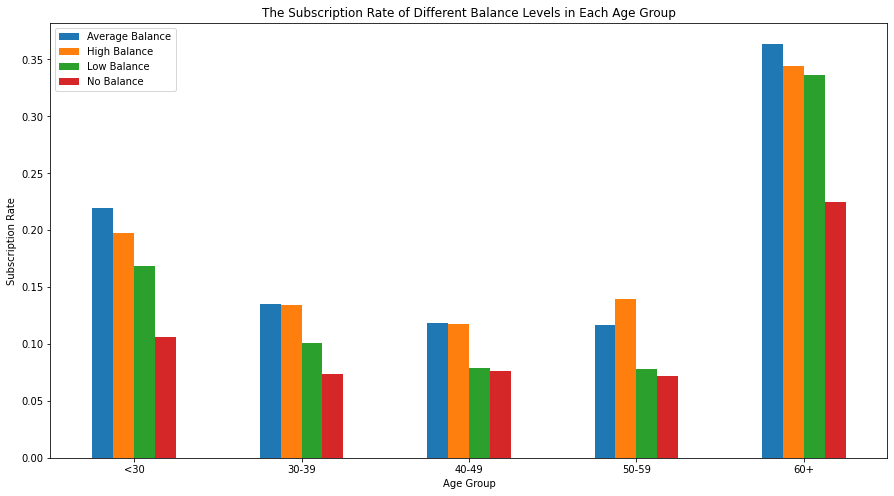

In [53]:
age_bal = age_balance1.plot(kind='bar',figsize = (15,8))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

Insights: 

While age represents a person’s life stage and balance represents a person’s financial condition, jointly evaluating the impact of these two factors enables us to investigate if there is a common trend across all ages, and to identify which combination of client features indicates the highest likelihood of subscription.

In order to investigate the combined effect of age and balance on a client’s decision, we performed a two-layer grouping, segmenting customers according to their balance levels within each age group.

The graph tells the same story regarding the subscription rate for different age groups: the willingness to subscribe is exceptionally high for people aged above 60 and younger people aged below 30 also have a distinguishable higher subscription rate than those of other age groups.
Furthermore, the effect of balance levels on subscription decision is applicable to each individual age group: every age group shares a common trend that the percentage of subscription increases with balance.

**Visualize the subscription rate by job**

In [54]:
count_job_deposit_pct = pd.crosstab(df_clean5['deposit'],df_clean5['job']).apply(lambda x: x/x.sum() * 100)
count_job_deposit_pct = count_job_deposit_pct.transpose()

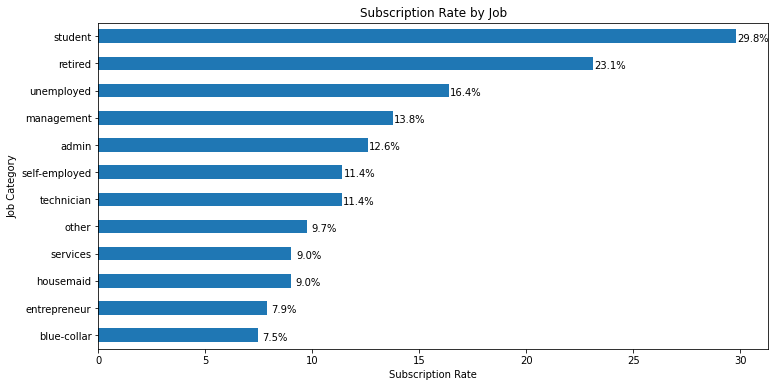

In [55]:
plot_job = count_job_deposit_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))
                                                                               
plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_deposit_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8, 
                  rec.get_y()+ rec.get_height()-0.5, 
                  label+'%', 
                  ha = 'center', 
                  va='bottom')

As noted from the horizontal bar chart, students and retired clients account for more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.

# **Data Pre-Modeling**



---



## **Feature Selection**

Only the most relevant customer information is considered, which includes job title, education, marital status, age, balance, default record, housing record and loan record. Other information, such as ‘the number of contacts performed before this campaign’, is omitted because it is not directly related to customers themselves.

In [58]:
from google.colab import drive
drive.mount('/content/drive')
data_model = pd.read_csv('drive/My Drive/bank_cleaned.csv', delimiter=",")
data_model = data_model.drop(['Unnamed: 0'], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
data_model.head()


,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,response,response_binary
0,58,management,married,tertiary,no,2143,yes,no,5,may,4.35,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,5,may,2.52,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,1.27,1,-1,0,unknown,no,0
3,35,management,married,tertiary,no,231,yes,no,5,may,2.32,1,-1,0,unknown,no,0
4,28,management,single,tertiary,no,447,yes,yes,5,may,3.62,1,-1,0,unknown,no,0


Since machine learning algorithms only take numerical values, all five categorical variables (job, education, default, housing and loan) are transformed into dummy variables.

Dummy variables were used instead of continuous integers because these categorical variables are not ordinal. They simply represent different types rather than levels, so dummy variables are ideal to distinguish the effect of different categories.



In [60]:
data_model.drop(['marital'],axis=1, inplace=True)
data_model1 = data_model.iloc[:, 0:7]

In [61]:
data_model1.head()

,age,job,education,default,balance,housing,loan
0,58,management,tertiary,no,2143,yes,no
1,44,technician,secondary,no,29,yes,no
2,33,entrepreneur,secondary,no,2,yes,yes
3,35,management,tertiary,no,231,yes,no
4,28,management,tertiary,no,447,yes,yes


In [62]:
#Label Encoder
data_model2 = pd.get_dummies(data_model1, columns = ['job'])
data_model2 = pd.get_dummies(data_model2, columns = ['education'])

#One hot Encoding
data_model2['housing'] = data_model2['housing'].map({'yes': 1, 'no': 0})
data_model2['default'] = data_model2['default'].map({'yes': 1, 'no': 0})
data_model2['loan'] = data_model2['loan'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(data_model['response_binary'])
data_model2 = pd.merge(data_model2, dataset_response, left_index = True, right_index = True)
data_model2 = data_model2.query('balance >= 0')

In [63]:
data_model2

,age,default,balance,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,response_binary
0,58,0,2143,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,44,0,29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,33,0,2,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,35,0,231,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,28,0,447,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40836,25,0,505,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
40837,51,0,825,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1
40838,71,0,1729,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
40839,72,0,5715,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1


In [64]:
data_model2.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_other', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'education_primary', 'education_secondary', 'education_tertiary',
       'response_binary'],
      dtype='object')

In [65]:
data_model2.describe()

,age,default,balance,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,response_binary
count,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000,37337.000000
mean,40.912955,0.009535,1204.595442,0.543563,0.151646,0.113801,0.208640,0.033024,0.029756,0.215015,0.004125,0.050995,0.036425,0.089643,0.018239,0.169751,0.030586,0.159092,0.527868,0.313041,0.118917
std,10.591927,0.097181,1731.377198,0.498105,0.358682,0.317574,0.406342,0.178700,0.169916,0.410838,0.064091,0.219990,0.187348,0.285673,0.133817,0.375419,0.172196,0.365766,0.499229,0.463737,0.323695
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,137.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,514.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,0.000000,1480.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,95.000000,1.000000,10443.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Modeling Data**



---



In [66]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

In [67]:
#modified by changing dataset into pandas format
X = data_model2.drop('response_binary',axis=1)
y = data_model2[['response_binary']]
print(y.shape)

(37337, 1)


##**Train Split Data**

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

#Train test split
#Using 20% data for data test
test_size= 0.20
seed = 7
X_train, X_test, Y_train, Y_test=\
train_test_split(X.to_numpy(), y.to_numpy(), test_size=test_size, random_state=seed)

##**Fitting Model**

5 different classification algorithms (Logistic Regression, K-Neighbors Classifier, Decision Tree Classifier, Gaussian NB and XGboost) are run on the dataset and the best-performing one will be used to build the classification model.

In [69]:
#Comparing Model Algorithm
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
model = []
model.append(('LR', LogisticRegression(solver='liblinear')))
model.append(('KNN', KNeighborsClassifier()))
model.append(('CART', DecisionTreeClassifier()))
model.append(('NB', GaussianNB()))
model.append(('XG', xgb.XGBClassifier()))

model_name=[]
i=0
from sklearn.model_selection import cross_validate, KFold
prediction=list()
kf = KFold(n_splits=5, shuffle= True)
Xk,Yk = X.to_numpy(), y.to_numpy()
trn_tst_ind=list()
for train_index, test_index in kf.split(Xk):
    trn_tst_ind.append((train_index, test_index))
    X_res, X_test = Xk[train_index], Xk[test_index]
    Y_res, Y_test = Yk[train_index], Yk[test_index]    
    sm = SMOTE(random_state=42)
    X_res, Y_res = sm.fit_resample(X_res, Y_res)
    predict=np.empty([X_test.shape[0],len(model)])
    i=0
    for name,mod in model:
        predict[:,i]=mod.fit(X_res, Y_res).predict(X_test)
        model_name.append(name)
        i+=1
    prediction.append(predict)    


In [70]:
print("Train data shape:{}".format(X_res.shape))
print("Test data shape:{}".format(X_test.shape))

Train data shape:(52690, 20)
Test data shape:(7467, 20)


## **Majority voting model**

We find that using the voting method improve the prediction results of minority class, i.e., f-score, without reducing the performance of the majority class

In [71]:
#Fitting all modeling Algorithms on the test set to find the best
from sklearn.metrics import classification_report
for page in range(3):
    print(f'page: {page}')
    predict=prediction[page]
    test_index = trn_tst_ind[page][1]
    for ind in range(len(model)):
        print(f'model name:{model_name[ind]}: accuracy:{accuracy_score(Yk[test_index], predict[:,ind]):.2f}')
        print(classification_report(Yk[test_index], predict[:,ind]))        


page: 0
model name:LR: accuracy:0.87
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      6596
           1       0.34      0.12      0.18       872

    accuracy                           0.87      7468
   macro avg       0.62      0.54      0.55      7468
weighted avg       0.83      0.87      0.84      7468

model name:KNN: accuracy:0.65
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      6596
           1       0.17      0.51      0.26       872

    accuracy                           0.65      7468
   macro avg       0.54      0.59      0.52      7468
weighted avg       0.83      0.65      0.71      7468

model name:CART: accuracy:0.82
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      6596
           1       0.27      0.33      0.30       872

    accuracy                           0.82      7468
   macro avg       0.59      0

**We choose XGboost as our model**

In [72]:
#XGboost with oversampling SMOTE & Normalization (MinMaxScaler)
from sklearn.preprocessing import MinMaxScaler
sampling_time = 25
import xgboost as xgb
model=xgb.XGBClassifier()
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_train, Y_train)
mmx_scale = MinMaxScaler()
X_scale = mmx_scale.fit_transform(X_res)
predict=np.empty([X_test.shape[0],sampling_time])
proj_dim = np.floor(X_test.shape[1]/1.7).astype(int)
w_rand=np.random.normal(0,1,size=(X_test.shape[1],int(sampling_time*proj_dim)))
i=0
for samp in range(sampling_time):
    w_ = w_rand[:,int(samp*proj_dim):int((samp+1)*proj_dim)]
    predict[:,i]=model.fit(np.matmul(X_scale,w_), Y_res).predict(np.matmul(mmx_scale.transform(X_test),w_))
    i+=1
    


## **Evaluation**

accuracy:0.85
607
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6552
           1       0.31      0.20      0.25       915

    accuracy                           0.85      7467
   macro avg       0.60      0.57      0.58      7467
weighted avg       0.82      0.85      0.83      7467



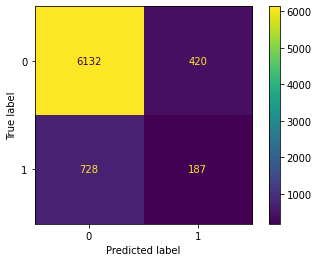

In [73]:
#Make Classfication Report & Confusion Matrix
predict_maj = np.zeros((len(Y_test),))
predict_maj[np.sum(predict,axis=1)>np.floor(sampling_time/2)]=1
print(f'accuracy:{accuracy_score(Y_test, predict_maj):.2f}')
print(sum(predict_maj==1))
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test,predict_maj)
print(classification_report(Y_test, predict_maj))

## **Feature Importance**

<Figure size 1080x576 with 0 Axes>

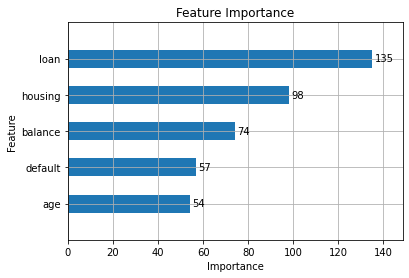

In [74]:
plt.figure(figsize=(15, 8))
xgboost.plot_importance(model, title='Feature Importance', xlabel='Importance', ylabel='Feature', max_num_features=5, height=0.5 )
# Tambahkan nama fitur di sisi y-axis
ax = plt.gca()
ax.set_yticklabels(X.columns)
plt.show()

## **Show Prediction result into Data Test**

In [75]:
df_test = pd.DataFrame(X_test, columns=['age', 'default', 'balance', 'housing', 'loan', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_other', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'education_primary', 'education_secondary', 'education_tertiary'])
# Create a dataframe with the predictions
df_test['predictions'] = predict_maj
df_test['true_labels'] = Y_test


# View the dataframe
df_test


,age,default,balance,housing,loan,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_other,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_primary,education_secondary,education_tertiary,predictions,true_labels
0,58,0,2143,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,0
1,44,0,29,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.0,0
2,35,0,231,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,0
3,32,0,23,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0
4,54,0,529,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7462,38,0,2543,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,1
7463,66,0,3409,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1.0,0
7464,32,0,1168,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.0,1
7465,53,0,583,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,1
